# Content Based Image Retrieval (CBIR)
## Deep Learning & KNN, KMeans

In [1]:
import time
import copy
import pickle
#from barbar import Bar
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
%matplotlib inline

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torchvision.models import vgg16, vgg19, resnet18
from torchsummary import summary

from tqdm import tqdm
from pathlib import Path
import gc
import os

In [2]:
# Find if any accelerator is presented, if yes switch device to use CUDA or else use CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
# preparing intermediate DataFrame
datasetPath = Path('oxford_buildings - Full/')
df = pd.DataFrame()

df['image'] = [f for f in os.listdir(datasetPath) if os.path.isfile(os.path.join(datasetPath, f))]
df['image'] = 'oxford_buildings - Full/' + df['image'].astype(str)

print(len(df))
df.head()

5063


,image
0,oxford_buildings - Full/all_souls_000000.jpg
1,oxford_buildings - Full/all_souls_000001.jpg
2,oxford_buildings - Full/all_souls_000002.jpg
3,oxford_buildings - Full/all_souls_000003.jpg
4,oxford_buildings - Full/all_souls_000005.jpg


# Fature Extraction Model

In [4]:
"""
# VGG16-19
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg16(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:-1])#18

    def forward(self, img):
        return self.feature_extractor(img)
    
summary(FeatureExtractor().to(device),(3,512//4,512//4))
""" 

'\n# VGG16-19\nclass FeatureExtractor(nn.Module):\n    def __init__(self):\n        super(FeatureExtractor, self).__init__()\n        vgg19_model = vgg16(pretrained=True)\n        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:-1])#18\n\n    def forward(self, img):\n        return self.feature_extractor(img)\n    \nsummary(FeatureExtractor().to(device),(3,512//4,512//4))\n'

In [5]:
rn18 = resnet18(pretrained=True)

children_counter = 0
for n,c in rn18.named_children():
    print("Children Counter: ",children_counter," Layer Name: ",n,)
    children_counter+=1

Children Counter:  0  Layer Name:  conv1
Children Counter:  1  Layer Name:  bn1
Children Counter:  2  Layer Name:  relu
Children Counter:  3  Layer Name:  maxpool
Children Counter:  4  Layer Name:  layer1
Children Counter:  5  Layer Name:  layer2
Children Counter:  6  Layer Name:  layer3
Children Counter:  7  Layer Name:  layer4
Children Counter:  8  Layer Name:  avgpool
Children Counter:  9  Layer Name:  fc


In [6]:
class FeatureExtractor(nn.Module):
    def __init__(self, output_layer):
        super().__init__()
        self.output_layer = output_layer
        self.pretrained = resnet18(pretrained=True)
        self.children_list = []
        for n,c in self.pretrained.named_children():
            self.children_list.append(c)
            if n == self.output_layer:
                break

        self.net = nn.Sequential(*self.children_list)
        self.pretrained = None
        
    def forward(self,x):
        x = self.net(x)
        return x
    
FeatureExtractor = FeatureExtractor(output_layer = 'layer4')
summary(FeatureExtractor.to(device),(3,128,128))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 4, 4]           --
|    └─Conv2d: 2-1                       [-1, 64, 64, 64]          9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 64, 64]          128
|    └─ReLU: 2-3                         [-1, 64, 64, 64]          --
|    └─MaxPool2d: 2-4                    [-1, 64, 32, 32]          --
|    └─Sequential: 2-5                   [-1, 64, 32, 32]          --
|    |    └─BasicBlock: 3-1              [-1, 64, 32, 32]          73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 32, 32]          73,984
|    └─Sequential: 2-6                   [-1, 128, 16, 16]         --
|    |    └─BasicBlock: 3-3              [-1, 128, 16, 16]         230,144
|    |    └─BasicBlock: 3-4              [-1, 128, 16, 16]         295,424
|    └─Sequential: 2-7                   [-1, 256, 8, 8]           --
|    |    └─BasicBlock: 3-5              [-1, 256, 8, 8]       

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 4, 4]           --
|    └─Conv2d: 2-1                       [-1, 64, 64, 64]          9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 64, 64]          128
|    └─ReLU: 2-3                         [-1, 64, 64, 64]          --
|    └─MaxPool2d: 2-4                    [-1, 64, 32, 32]          --
|    └─Sequential: 2-5                   [-1, 64, 32, 32]          --
|    |    └─BasicBlock: 3-1              [-1, 64, 32, 32]          73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 32, 32]          73,984
|    └─Sequential: 2-6                   [-1, 128, 16, 16]         --
|    |    └─BasicBlock: 3-3              [-1, 128, 16, 16]         230,144
|    |    └─BasicBlock: 3-4              [-1, 128, 16, 16]         295,424
|    └─Sequential: 2-7                   [-1, 256, 8, 8]           --
|    |    └─BasicBlock: 3-5              [-1, 256, 8, 8]       

# Inference

## 1. Indexing

In [7]:
transformations = transforms.Compose([
                  transforms.Resize((512//4,512//4)),
                  transforms.ToTensor(),
                  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# Load Model in Evaluation phase
model = FeatureExtractor.to(device)
model.eval()

FeatureExtractor(
  (pretrained): None
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [8]:
def get_latent_features(images, transformations, latent_dim = 512*4*4):#32//4*32//4

    latent_features = np.zeros((images.shape[0],latent_dim))
    
    for i,image in enumerate(tqdm(images)):
        tensor = transformations(Image.open(image)).to(device)
        latent_features[i] = model(tensor.unsqueeze(0)).view(-1).cpu().detach().numpy()
        
    del tensor
    gc.collect()
    return latent_features

In [9]:
images = df.image.values
latent_features = get_latent_features(images, transformations)
latent_features.shape

100%|██████████████████████████████████████████████████████████████████████████████| 5063/5063 [04:52<00:00, 17.28it/s]


(5063, 8192)

In [10]:
indexes = list(range(0, images.shape[0]))
feature_dict = dict(zip(indexes,latent_features))
index_dict = {'indexes':indexes,'features':latent_features}

In [11]:
"""
# write the data dictionary to disk
with open('cbir_checkpoints/features.pkl', "wb") as f:
    f.write(pickle.dumps(index_dict))
"""

'\n# write the data dictionary to disk\nwith open(\'cbir_checkpoints/features.pkl\', "wb") as f:\n    f.write(pickle.dumps(index_dict))\n'

## 2. Image Retrieval 

<font size="3"> This will be approached with two ways as discussed in the start:
    - Euclidean Search:
        - Identifying the Latent Features
        - Calculating the Euclidean Distance between them
        - Returning the closest N indexes (of images)
    
    - Locality Sensitive Hashing
        - Create hashes of the feature vector from Encoder
        - Store it in a Hashing Table
        - Identify closest images based on hamming distance

### 2.1 Euclidean Search Method

In [12]:
def euclidean(a, b):
    # compute and return the euclidean distance between two vectors
    return np.linalg.norm(a - b)

In [13]:
def cosine_distance(a,b):
    return scipy.spatial.distance.cosine(a, b)

In [14]:
def perform_search(queryFeatures, index, maxResults=10):

    results = []

    for i in range(0, len(index["features"])):
        # compute euclidean distance between our query features and features for current image in our index, 
        # then update our results list with a 2-tuple consisting of computed distance and index of the image
        d = euclidean(queryFeatures, index["features"][i])
        results.append((d, i))
    
    # sort the results and grab the top ones
    results = sorted(results, key=lambda i: i[0])[:maxResults]
    # return the list of results
    return results

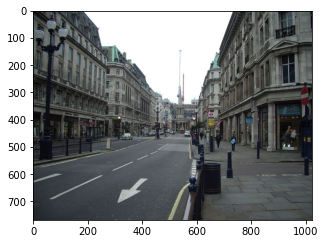

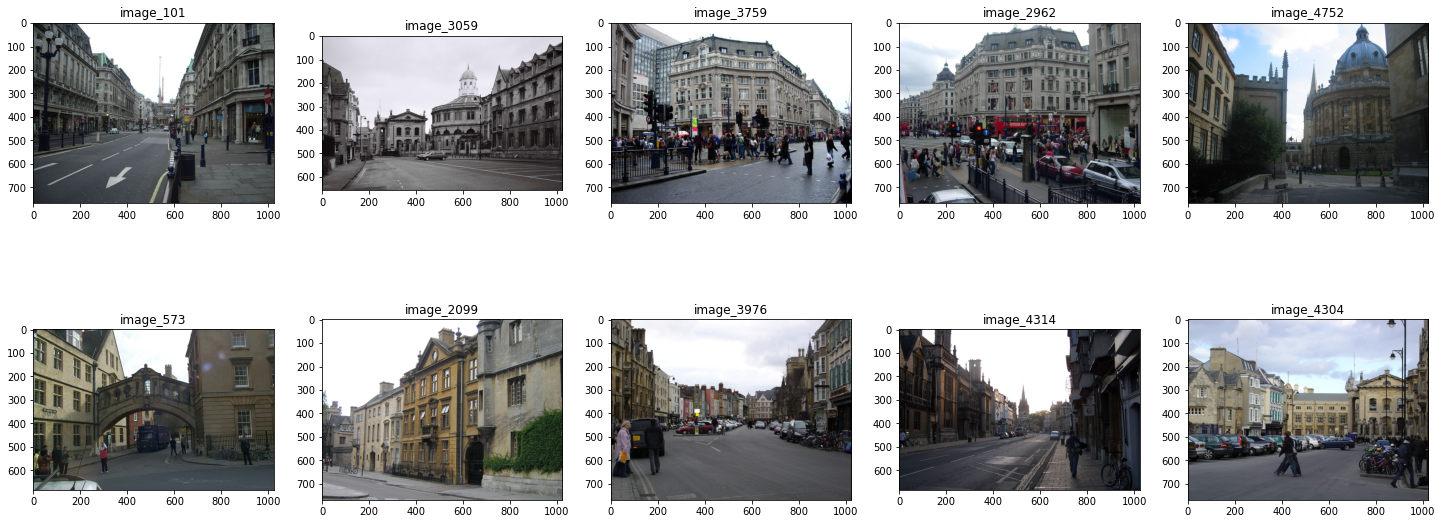

In [15]:
# take the features for the current image, find all similar images in our dataset, 
# and then initialize our list of result images

queryIdx = 100# Input Index for which images 
MAX_RESULTS = 10

queryFeatures = latent_features[queryIdx]
results = perform_search(queryFeatures, index_dict, maxResults=MAX_RESULTS)

# display the query image
plt.figure(figsize=(5,5))
plt.imshow(Image.open(images[queryIdx]))

# loop over the results
fig, axs = plt.subplots(2, 5, figsize=(25,10))
i=0
for (d, j) in results:
    img = Image.open(images[j])
    axs[i//5, i%5].imshow(img)
    axs[i//5, i%5].set_title(f"image_{j+1}")
    i+=1

In [16]:
testpath = Path('Test_Images')
testdf = pd.DataFrame()

testdf['image'] = [f for f in os.listdir(testpath) if os.path.isfile(os.path.join(testpath, f))]
testdf['image'] = 'Test_Images/' + testdf['image'].astype(str)

testimages = testdf.image.values
test_latent_features = get_latent_features(testimages, transformations)
test_latent_features.shape

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 16.44it/s]


(10, 8192)

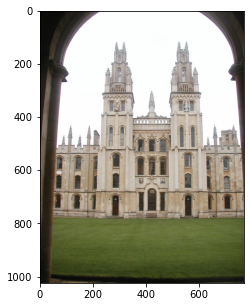

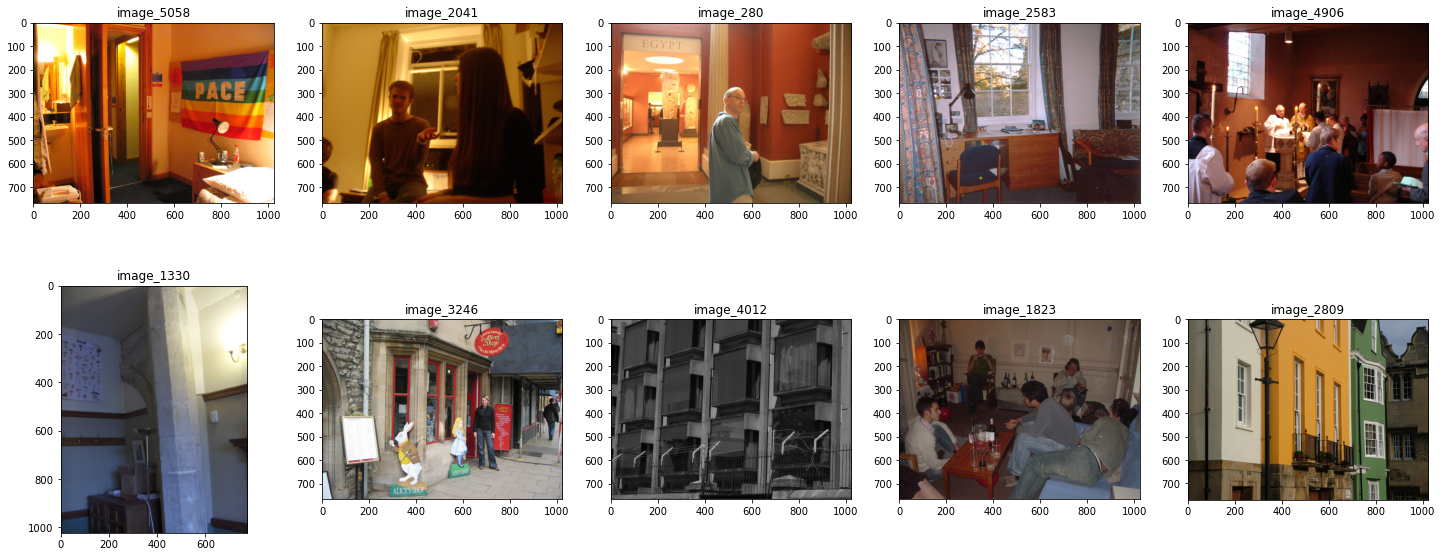

In [17]:
MAX_RESULTS = 10
queryIdx = 5

queryFeatures = test_latent_features[queryIdx]
results = perform_search(queryFeatures, index_dict, maxResults=MAX_RESULTS)

# display the query image
plt.figure(figsize=(5,5))
plt.imshow(Image.open(testimages[queryIdx]))

# loop over the results
fig, axs = plt.subplots(2, 5, figsize=(25,10))
i=0
for (d, j) in results:
    img = Image.open(images[j])
    axs[i//5, i%5].imshow(img)
    axs[i//5, i%5].set_title(f"image_{j+1}")
    i+=1

### 2.2 LSHashing Method

In [18]:
#!pip install lshashpy3
from lshashpy3 import LSHash

## Locality Sensitive Hashing
# params
k = 10 # hash size
L = 5  # number of tables
d = 512*4*4 # Dimension of Feature vector *32//4*32//4
lsh = LSHash(hash_size=k, input_dim=d, num_hashtables=L)

# # LSH on all the images
for idx,vec in tqdm(feature_dict.items()):
    lsh.index(vec, extra_data=idx)#vec.flatten()

100%|█████████████████████████████████████████████████████████████████████████████| 5063/5063 [00:39<00:00, 127.71it/s]


In [19]:
## Exporting as pickle
#pickle.dump(lsh, open('lsh.p', "wb"))

In [53]:
def get_similar_item(queryFeatures, feature_dict, lsh_variable, n_items=10):
    response = lsh_variable.query(queryFeatures, 
                                  num_results=n_items+1, distance_func='euclidean')#hamming
    lists = []
    imgs = []
    for i in range(1, n_items+1):
        lists.append(response[i][0][1])
        imgs.append(np.array(Image.open(images[response[i][0][1]])))
    return lists, imgs

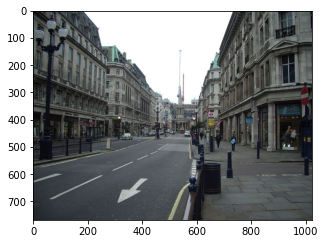

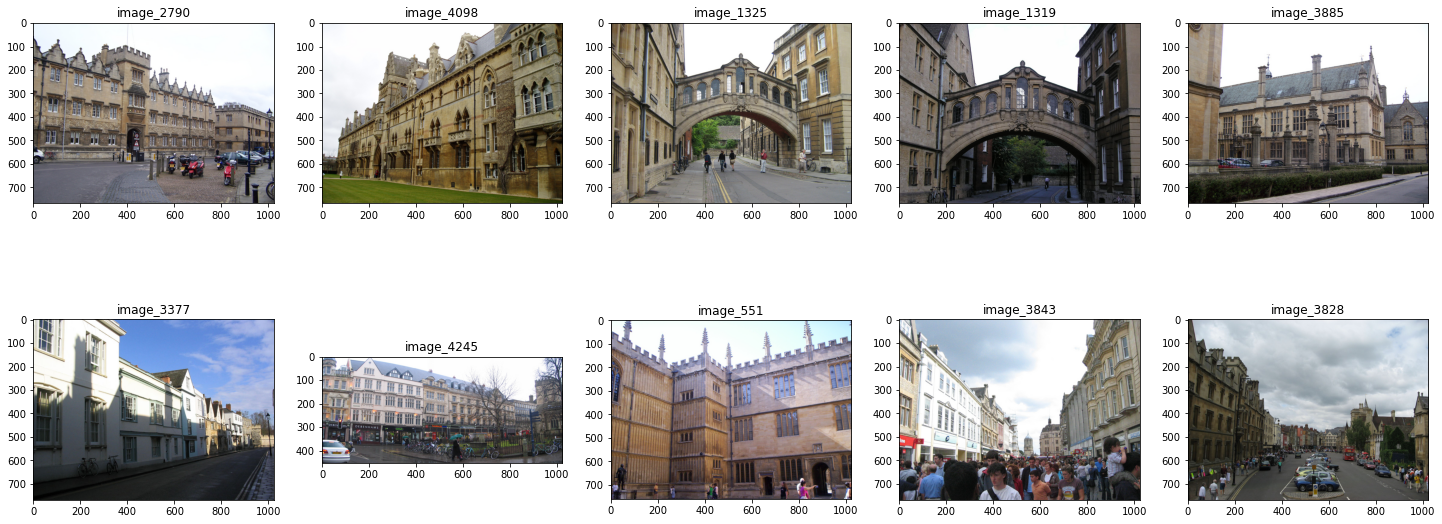

In [54]:
queryIdx = 100
queryFeatures = latent_features[queryIdx]

lists, results = get_similar_item(queryFeatures, feature_dict, lsh, 10)

# display the query image
plt.figure(figsize=(5,5))
plt.imshow(Image.open(images[queryIdx]))

# loop over the results
fig, axs = plt.subplots(2, 5, figsize=(25,10))
i=0
for j in range(10):
    img = results[j]
    axs[i//5, i%5].imshow(img)
    axs[i//5, i%5].set_title(f"image_{lists[j]+1}")
    i+=1

In [ ]:
queryIdx = 3
queryFeatures = test_latent_features[queryIdx]

lists, results = get_similar_item(queryFeatures, feature_dict, lsh, 10)

# display the query image
# display the query image
plt.figure(figsize=(5,5))
plt.imshow(Image.open(testimages[queryIdx]))

# loop over the results
fig, axs = plt.subplots(2, 5, figsize=(25,10))
i=0
for j in range(10):
    img = results[j]
    axs[i//5, i%5].imshow(img)
    axs[i//5, i%5].set_title(f"image_{lists[j]+1}")
    i+=1

# End Notes

- We started with the approach of AutoEncoders for Image Latent Features extraction followed by Image retrieval using Euclidean Distance which was an O(NlogN) approach (Time-Complexity) to Hashing which gave us an ~O(logN) approach

- Another approach was to use Hashing on features obtained from SIFT, SURF, OBS and building the VP Trees ans search the images in it.

![](https://www.pyimagesearch.com/wp-content/uploads/2019/08/image_hashing_search_engine_steps.png)

# Clustering of Images: Kmeans, kNearestNeighbors

In [22]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, MiniBatchKMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm
%matplotlib inline

In [23]:
def get_latent_features1D(images, transformations):
    
    latent_features1d = []
    
    for i,image in enumerate(tqdm(images)):
        tensor = transformations(Image.open(image)).to(device)
        latent_features1d.append(model(tensor.unsqueeze(0)).view(-1).cpu().detach().numpy())
        
    del tensor
    gc.collect()
    return latent_features1d

In [24]:
images = df.image.values
latent_features1d = get_latent_features1D(images, transformations)
latent_features1d = np.array(latent_features1d)

100%|██████████████████████████████████████████████████████████████████████████████| 5063/5063 [04:59<00:00, 16.92it/s]


In [ ]:
n_neighbors = 10
nn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')

nn.fit(latent_features1d)

#images[100]: name of query image
tensor  = transformations(Image.open(images[100])).to(device)
X = model(tensor.unsqueeze(0)).view(-1).cpu().detach().numpy()
indexes = nn.kneighbors(np.expand_dims(X,0), return_distance=False)

# loop over the results
fig, axs = plt.subplots(2, 5, figsize=(25,10))
i=0
for j in range(10):
    img = Image.open(images[indexes[0, j]])
    axs[i//5, i%5].imshow(img)
    axs[i//5, i%5].set_title(f"image_{indexes[0, j]+1}")
    i+=1

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:26<00:00, 34.44s/it]


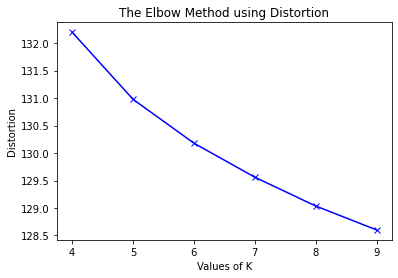

In [25]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(4,10) 
  
for k in tqdm(K): 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(latent_features1d)      
      
    distortions.append(sum(np.min(cdist(latent_features1d, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / latent_features1d.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(latent_features1d, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / latent_features1d.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 
    
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

In [ ]:
X = np.array(latent_features1d)
K = range(2,5) 

for n_clusters in tqdm(K):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                  fontsize=14, fontweight='bold')

plt.show()

## Using SIFT/SURF/ORB technique

In [ ]:
def build_dictionary(xfeatures2d, images, n_clusters):
    #print('Computing descriptors..')        
    desc_list = []
    
    for image_path in images:
        gray = cv2.imread(image_path,0)
        kp, dsc = xfeatures2d.detectAndCompute(gray, None)
        if dsc is None:
            desc_list.extend(np.zeros((1000,32)))
        else:    
            desc_list.extend(dsc)

    desc = np.array(desc_list)
    #print('Creating BoW dictionary using K-Means clustering with k={}..'.format(n_clusters))
    dictionary = MiniBatchKMeans(n_clusters=n_clusters, batch_size=1000, verbose=0)
    dictionary.fit(desc)
    
    distortion = sum(np.min(cdist(desc, dictionary.cluster_centers_, 
                     'euclidean'),axis=1)) / desc.shape[0]
    
    return distortion

In [ ]:
orb = cv2.ORB_create(1000)
images = df.image.values
K = range(4,10)
distortions = []

for k in tqdm(K):
    distortions.append(build_dictionary(orb, images, n_clusters=k))
    
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 